# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [25]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

### Dataset loading and preprocessing

In [26]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

In [27]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Data_folder/Picture.csv", header= None)

#print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = data_matrix.iloc[:,0].values
        y1 = data_matrix.iloc[:,1].values
        
        # Add normalization for x
        # x = preprocessing.normalize(x)
        # y = preprocessing.normalize(y, axis = 0,norm='l2')


        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)


### Load data for PictureNet

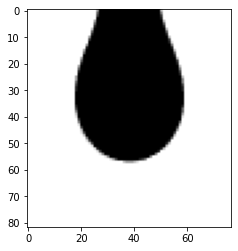

In [28]:
train_img = []

data_image = pd.read_csv("Data_folder/Picture.csv", header= None)
for img_name in data_image.iloc[0:32,3:].index + 1:
    # defining the image path
    image_path = 'Data_folder/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
    
plt.imshow(train_img[0], cmap='gray')

# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic = data_image.iloc[0:32,3:].values
train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(train_x_pic, train_y_pic, test_size = 0.2)
val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)
# (train_x_pic.shape, train_y_pic.shape), (val_x_pic.shape, val_y_pic.shape), (test_x_pic.shape, test_y_pic.shape)

# converting the trian images and targets into torch format
train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
train_x_pic  = torch.from_numpy(train_x_pic)
train_y_pic = torch.from_numpy(train_y_pic)
# train_y_pic.shape, train_x_pic.shape

# converting the val images and targets into torch format
val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
val_x_pic  = torch.from_numpy(val_x_pic)
val_y_pic = torch.from_numpy(val_y_pic)
# val_x_pic.shape, val_y_pic.shape

# converting the test images and targets into torch format
test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
test_x_pic  = torch.from_numpy(test_x_pic)
test_y_pic = torch.from_numpy(test_y_pic)
# test_x_pic.shape, test_y_pic.shape

# converting the dataset into mini-batch dataset (input 4D -> 5D)
# To be finished after increaing pictures!!!!

### Deside to apply host or device


In [5]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


### Define the functions we need

In [6]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t].reshape(1, 1, 82, 77)        # reshape to 4D data (take it off after adding batch) 
            y = y_dataset[t].reshape(1, 160)              # reshape to 2D data (take it off after adding batch) 
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def train_physics(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t].reshape(1, 1, 82, 77)      # reshape to 4D data (take it off after adding batch) 
            y = train_y_pic[t].reshape(1, 160)            # reshape to 2D data (take it off after adding batch) 
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


### Train PhysicsNet

epoch 1: train_loss = 749.2071, val_loss = 822.9939
epoch 2: train_loss = 684.6441, val_loss = 745.5285
epoch 3: train_loss = 604.5455, val_loss = 659.3475
epoch 4: train_loss = 507.7782, val_loss = 554.6248
epoch 5: train_loss = 431.7234, val_loss = 469.4318
epoch 6: train_loss = 251.6098, val_loss = 269.2027
epoch 7: train_loss = 163.2213, val_loss = 177.9624
epoch 8: train_loss = 89.9333, val_loss = 96.3629
epoch 9: train_loss = 57.6520, val_loss = 62.9599
epoch 10: train_loss = 31.7244, val_loss = 34.3513
epoch 11: train_loss = 14.8122, val_loss = 16.0791
epoch 12: train_loss = 20.7405, val_loss = 22.2442
epoch 13: train_loss = 7.1325, val_loss = 7.2944
epoch 14: train_loss = 1.6043, val_loss = 1.7031
epoch 15: train_loss = 1.0501, val_loss = 1.0646
epoch 16: train_loss = 0.7204, val_loss = 0.7610
epoch 17: train_loss = 0.5578, val_loss = 0.5767
epoch 18: train_loss = 0.4339, val_loss = 0.4571
epoch 19: train_loss = 0.4717, val_loss = 0.4632
epoch 20: train_loss = 0.3920, val_loss 

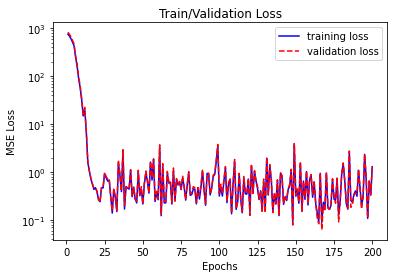

In [8]:
in_channel = 160
node_1 = 4096
node_2 = 4096
node_3 = 1024
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

train_physics(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)

### Visualization of outcomes

In [16]:
model_physics_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_physics_trained, x_test_example)
# y = data_matrix.iloc[0:,0:2].values
#Revert normalized values back to real values
# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:15])
print("Prediction    =", score_example[:15].reshape(15, 2))

Ground Truths = tensor([[39.1000, 10.5000],
        [37.2000, 16.1000],
        [35.6000, 15.8000],
        [31.7000, 12.5000],
        [30.2000, 13.6000],
        [30.3000, 14.4000],
        [36.8000, 16.6000],
        [39.7000, 17.3000],
        [39.0000, 12.6000],
        [42.4000, 12.2000],
        [42.7000, 14.2000],
        [39.1000, 15.3000],
        [37.6000, 16.2000],
        [37.6000, 13.2000],
        [40.9000, 12.3000]])
Prediction    = tensor([[35.3949, 10.4888],
        [37.1707, 16.1843],
        [35.3969, 15.7582],
        [31.0883, 12.4212],
        [30.2223, 13.2509],
        [30.2065, 14.5878],
        [36.7027, 16.5998],
        [39.8592, 17.4013],
        [37.1207, 12.7258],
        [39.1790, 12.4209],
        [40.4782, 14.7821],
        [38.6280, 15.4821],
        [37.5632, 16.2437],
        [36.3071, 13.3006],
        [38.0053, 12.4117]])


### Train PictureNet

epoch 1: train_loss = 3407.7341, val_loss = 4894.6240
epoch 2: train_loss = 1588.9023, val_loss = 2280.6641
epoch 3: train_loss = 8240.3672, val_loss = 11843.1387
epoch 4: train_loss = 703.8987, val_loss = 1018.0679
epoch 5: train_loss = 3.8634, val_loss = 5.3802
epoch 6: train_loss = 0.1322, val_loss = 0.1787
epoch 7: train_loss = 0.2028, val_loss = 0.2107
epoch 8: train_loss = 0.1368, val_loss = 0.2606
epoch 9: train_loss = 0.0756, val_loss = 0.1532
epoch 10: train_loss = 0.0484, val_loss = 0.0198
epoch 11: train_loss = 0.1053, val_loss = 0.2115
epoch 12: train_loss = 0.1872, val_loss = 0.3752
epoch 13: train_loss = 0.0289, val_loss = 0.0621
epoch 14: train_loss = 0.0578, val_loss = 0.1324
epoch 15: train_loss = 0.1192, val_loss = 0.2612
epoch 16: train_loss = 0.0260, val_loss = 0.0626
epoch 17: train_loss = 0.0237, val_loss = 0.0456
epoch 18: train_loss = 0.0200, val_loss = 0.0189
epoch 19: train_loss = 0.0185, val_loss = 0.0148
epoch 20: train_loss = 0.0242, val_loss = 0.0606
epoch

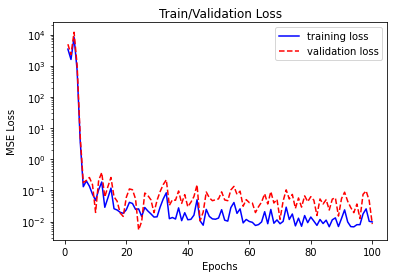

In [29]:
in_channel = 1
channel_1 = 64
channel_2 = 128
channel_3 = 256
node_1 = 4096
node_2 = 4096
out_channel = 160

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 100

train_picture(model_picture, optimizer, epoch)
PATH_PIC = os.path.join(os.getcwd(), "model_pic")
torch.save(model_picture, PATH_PIC)

### Visualization of outcomes

In [30]:
# testing cell
train_x_pic, train_y_pic

for t in range(len(train_x_pic)):
    pass
print(train_x_pic[t].shape)
print(train_y_pic[t].shape)

torch.Size([1, 82, 77])
torch.Size([160])


In [51]:
# To be done!!!
import random

model_picture_trained = torch.load(PATH_PIC)

rand = random.randint(0, len(test_x_pic)-1)
score_example = prediction(model_picture_trained, test_x_pic[rand].reshape(1, 1, 82, 77))
for num in range(len(test_y_pic[rand])):
    print(num+1, ": Ground Truths =", test_y_pic[rand, num].item(), ", Prediction =", score_example[0, num].item())


1 : Ground Truths = 4.35431090804292e-25 , Prediction = 0.019834602251648903
2 : Ground Truths = 0.0455693099088695 , Prediction = 0.054770976305007935
3 : Ground Truths = 0.0910670075826488 , Prediction = 0.08129695057868958
4 : Ground Truths = 0.136426319303317 , Prediction = 0.1786823719739914
5 : Ground Truths = 0.181573802930823 , Prediction = 0.20004165172576904
6 : Ground Truths = 0.226432012198012 , Prediction = 0.2518894672393799
7 : Ground Truths = 0.270958844927119 , Prediction = 0.2991119623184204
8 : Ground Truths = 0.315059923529246 , Prediction = 0.3087072968482971
9 : Ground Truths = 0.358676355723067 , Prediction = 0.3825976848602295
10 : Ground Truths = 0.401765455250373 , Prediction = 0.38040345907211304
11 : Ground Truths = 0.444228159634089 , Prediction = 0.46952810883522034
12 : Ground Truths = 0.486042218497721 , Prediction = 0.5467274188995361
13 : Ground Truths = 0.527134265551479 , Prediction = 0.5394445061683655
14 : Ground Truths = 0.567418408531099 , Predic